### Useful References
https://forum.pyro.ai/t/how-to-define-a-likelihood-function-in-numpyro/2968

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import os

from datetime import date, timedelta

import numpy as np
import jax.numpy as jnp
from jax import random, vmap

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import mechafil.data as mecha_data
import mechafil.sim as np_sim
import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting

import cel_utils.disk_utils as du

In [3]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 6, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*1
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-06-01 2023-06-26 2024-06-25


In [35]:
storage_dir='input_hmc'
figdir = 'input_hmc_figures'
os.makedirs(storage_dir, exist_ok=True)
os.makedirs(figdir, exist_ok=True)

In [11]:
sector_duration = 360
lock_target = 0.3
y = np.exp(lock_target) * jnp.ones(forecast_length)

def model():
    rbp_trajectory = numpyro.sample("rbp", dist.Gamma(5, 2).expand((forecast_length,)))
    rr_trajectory = numpyro.sample("fpr", dist.Beta(2, 2).expand((forecast_length,)))
    fpr_trajectory = numpyro.sample("rr", dist.Beta(3, 1).expand((forecast_length,)))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1.0).expand((forecast_length,)))  # models the variance on the observed lock target
    
    simulation_results = sim.run_sim(
        rbp_trajectory,
        rr_trajectory,
        fpr_trajectory,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    
    l_over_cs = simulation_results['network_locked'][-forecast_length:]/simulation_results['circ_supply'][-forecast_length:]
    numpyro.sample("L_over_CS_target", dist.LogNormal(l_over_cs, sigma).expand((forecast_length,)), obs=y)

In [13]:
@du.cache_data(directory=storage_dir)
def run_mcmc():
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS.
    kernel = NUTS(model)
    num_samples = 500
    mcmc = MCMC(kernel, num_warmup=500, num_samples=num_samples)
    mcmc.run(rng_key_)
    
    return {'mcmc': mcmc}

mcmc = run_mcmc()['mcmc']

sample: 100%|██████████████████████████████████████████████████████| 1000/1000 [16:58<00:00,  1.02s/it, 1023 steps of size 4.87e-03. acc. prob=0.80]


In [14]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    fpr[0]      0.50      0.25      0.50      0.14      0.96    121.22      1.01
    fpr[1]      0.66      0.25      0.74      0.26      0.98    156.08      1.00
    fpr[2]      0.65      0.21      0.68      0.34      0.98    274.07      1.00
    fpr[3]      0.44      0.24      0.42      0.04      0.82    144.66      1.00
    fpr[4]      0.95      0.03      0.96      0.91      1.00    154.51      1.02
    fpr[5]      0.54      0.22      0.54      0.22      0.92    175.60      1.01
    fpr[6]      0.54      0.25      0.54      0.11      0.88    334.50      1.01
    fpr[7]      0.50      0.24      0.48      0.14      0.91    380.67      1.00
    fpr[8]      0.71      0.20      0.76      0.39      0.99     91.88      1.00
    fpr[9]      0.54      0.26      0.57      0.13      0.92    250.10      1.00
   fpr[10]      0.58      0.25      0.61      0.19      0.95    187.80      1.00
   fpr[11]      0.54      0

In [15]:
samps = mcmc.get_samples()

In [16]:
total_sim_len = (end_date - current_date).days
t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

In [28]:
# run the simulation on several quantiles
qvec = [.05, .25, .50, .75, .95]
quantile_results = {}
for q in qvec:
    rbp = np.quantile(samps['rbp'], q, axis=0)
    rr = np.quantile(samps['rr'], q, axis=0)
    fpr = np.quantile(samps['fpr'], q, axis=0)
    
    simulation_results = sim.run_sim(
        rbp,
        rr,
        fpr,
        lock_target,

        start_date,
        current_date,
        forecast_length,
        sector_duration,
        offline_data
    )
    quantile_results[q] = simulation_results

<IPython.core.display.Javascript object>


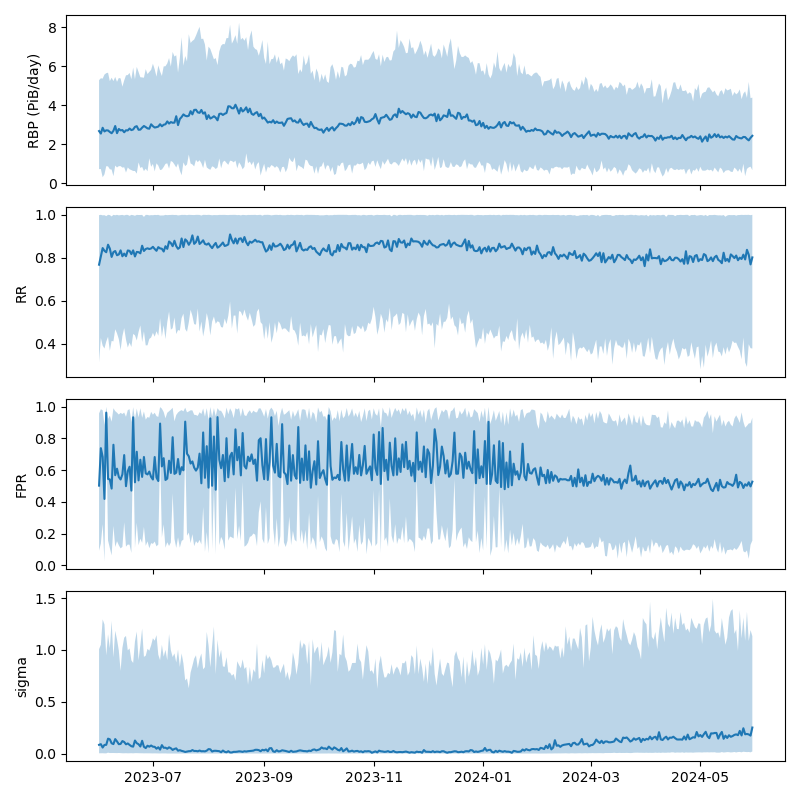

In [29]:
fig, ax = plt.subplots(nrows=4,ncols=1,sharex=True, figsize=(8,8))

key = 'rbp'
bands = hpdi(samps[key], 0.95)
ax[0].plot(t, np.median(samps[key], axis=0))
ax[0].fill_between(t, bands[0], bands[1], alpha=0.3)
ax[0].set_ylabel('RBP (PiB/day)')

key = 'rr'
bands = hpdi(samps[key], 0.95)
ax[1].plot(t, np.median(samps[key], axis=0))
ax[1].fill_between(t, bands[0], bands[1], alpha=0.3)
ax[1].set_ylabel('RR')

key = 'fpr'
bands = hpdi(samps[key], 0.95)
ax[2].plot(t, np.median(samps[key], axis=0))
ax[2].fill_between(t, bands[0], bands[1], alpha=0.3)
ax[2].set_ylabel('FPR')

key = 'sigma'
bands = hpdi(samps[key], 0.95)
ax[3].plot(t, np.median(samps[key], axis=0))
ax[3].fill_between(t, bands[0], bands[1], alpha=0.3)
ax[3].set_ylabel('sigma')

plt.tight_layout()

<IPython.core.display.Javascript object>


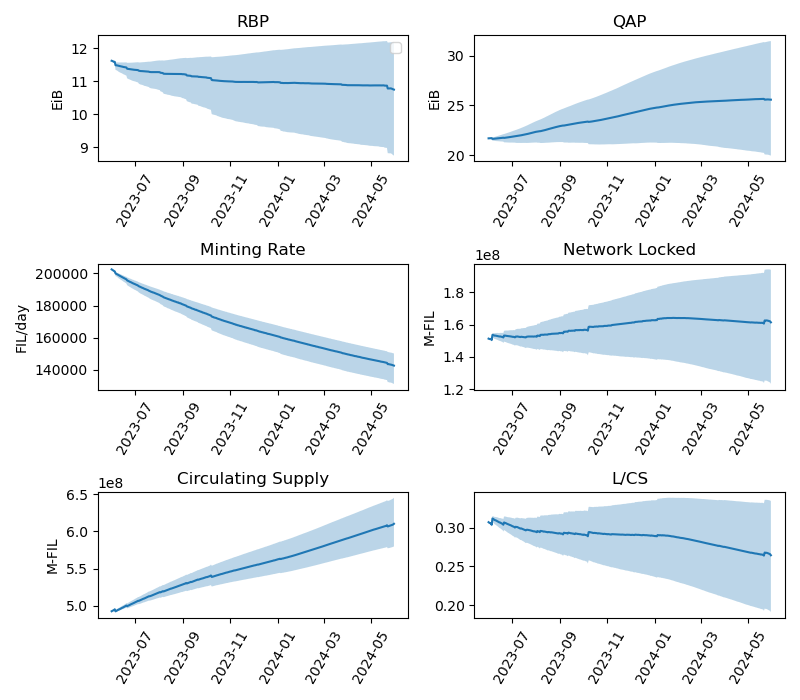

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [36]:
plt.figure(figsize=(8,7))

k = 'rb_total_power_eib'
plt.subplot(3,2,1)
plt.plot(t, quantile_results[0.50][k][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k][-forecast_length:], quantile_results[0.75][k][-forecast_length:], alpha=0.3)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('RBP')
plt.legend()

k = 'qa_total_power_eib'
plt.subplot(3,2,2)
plt.plot(t, quantile_results[0.50][k][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k][-forecast_length:], quantile_results[0.75][k][-forecast_length:], alpha=0.3)
plt.xticks(rotation=60)
plt.ylabel('EiB')
plt.title('QAP')

k = 'day_network_reward'
plt.subplot(3,2,3)
plt.plot(t, quantile_results[0.50][k][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k][-forecast_length:], quantile_results[0.75][k][-forecast_length:], alpha=0.3)
plt.xticks(rotation=60)
plt.title('Minting Rate')
plt.ylabel('FIL/day')

k = 'network_locked'
plt.subplot(3,2,4)
plt.plot(t, quantile_results[0.50][k][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k][-forecast_length:], quantile_results[0.75][k][-forecast_length:], alpha=0.3)
plt.xticks(rotation=60)
plt.title('Network Locked')
plt.ylabel('M-FIL')

k = 'circ_supply'
plt.subplot(3,2,5)
plt.plot(t, quantile_results[0.50][k][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k][-forecast_length:], quantile_results[0.75][k][-forecast_length:], alpha=0.3)
plt.xticks(rotation=60)
plt.title('Circulating Supply')
plt.ylabel('M-FIL')

k1 = 'network_locked'
k2 = 'circ_supply'
plt.subplot(3,2,6)
plt.plot(t, quantile_results[0.50][k1][-forecast_length:]/quantile_results[0.50][k2][-forecast_length:])
plt.fill_between(t, quantile_results[0.25][k1][-forecast_length:]/quantile_results[0.25][k2][-forecast_length:], 
                 quantile_results[0.75][k1][-forecast_length:]/quantile_results[0.75][k2][-forecast_length:], 
                 alpha=0.3)
plt.xticks(rotation=60)
plt.title('L/CS')

plt.tight_layout()
plt.savefig(os.path.join(figdir, 'hmc.png'))